# Предобученный UNet для семантической сегментации

В этом ноутбуке мы реализуем обучение предобученной модели UNet для семантической сегментации на датасете CamVid. Используем PyTorch Lightning для обучения модели.


## Установка зависимостей

Устанавливаем библиотеку segmentation_models_pytorch для работы с предобученными моделями сегментации.


In [1]:
%pip install -q segmentation-models-pytorch albumentations
%pip install pytorch_lightning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 72.4 MB/s eta 0:00:00


## Импорты и настройка

Импортируем необходимые библиотеки для работы с предобученным UNet, PyTorch Lightning и обработки данных.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

torch.manual_seed(42)
np.random.seed(42)
pl.seed_everything(42)


INFO:lightning_fabric.utilities.seed:Seed set to 42


42

## Аугментации данных

Определяем аугментации для обучения и валидации с использованием библиотеки albumentations.


In [3]:
def get_train_augmentation(img_size=(512, 512)):
    return A.Compose([
        A.Resize(img_size[0], img_size[1]),
        A.HorizontalFlip(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        A.CoarseDropout(num_holes_range = (1, 8), hole_height_range = (0.1, 0.2), hole_width_range = (0.1, 0.2), fill = 0, fill_mask = None, p=0.5),
        A.ElasticTransform(alpha=30, sigma=15, p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

def get_val_augmentation(img_size=(512, 512)):
    return A.Compose([
        A.Resize(img_size[0], img_size[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


## Датасет для сегментации

Используем CamVid для семантической сегментации. Датасет содержит 12 классов дорожных сцен.


In [4]:
class CamVidDataset(Dataset):
    def __init__(self, data_dir, split='train', img_size=(512, 512), transform=None):
        self.data_dir = data_dir
        self.img_size = img_size
        self.transform = transform

        txt_file = os.path.join(data_dir, split + '.txt')
        self.samples = []

        with open(txt_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split()
                    if len(parts) >= 2:
                        img_path_abs = parts[0]
                        mask_path_abs = parts[1]

                        img_filename = os.path.basename(img_path_abs)
                        mask_filename = os.path.basename(mask_path_abs)

                        img_path = os.path.join(data_dir, split, img_filename)
                        mask_path = os.path.join(data_dir, split + 'annot', mask_filename)

                        if os.path.exists(img_path) and os.path.exists(mask_path):
                            self.samples.append((img_path, mask_path))

        print("Loaded {} samples from {} split".format(len(self.samples), split))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'))

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

            if isinstance(image, np.ndarray):
                image = torch.from_numpy(image).permute(2, 0, 1).float()
            if isinstance(mask, np.ndarray):
                mask = torch.from_numpy(mask).long()
        else:
            image = Image.fromarray(image).resize(self.img_size, Image.BILINEAR)
            image = np.array(image).astype(np.float32) / 255.0
            mask = Image.fromarray(mask).resize(self.img_size, Image.NEAREST)
            mask = np.array(mask).astype(np.int64)

            image = torch.from_numpy(image).permute(2, 0, 1)
            mask = torch.from_numpy(mask)

        return image, mask


## Архитектура предобученного UNet

Используем предобученную модель UNet из библиотеки segmentation_models_pytorch. UNet с предобученным энкодером ResNet34 обеспечивает хорошее качество сегментации.


In [5]:
encoder_name = "resnet50"
encoder_weights = "imagenet"

model = smp.Unet(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    in_channels=3,
    classes=12,
)

print(f"Model: UNet with {encoder_name} encoder")
print(f"Encoder weights: {encoder_weights}")
print(f"Number of classes: 12")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Model: UNet with resnet50 encoder
Encoder weights: imagenet
Number of classes: 12
Number of parameters: 32,522,700


## Lightning модуль для обучения

Создаём PyTorch Lightning модуль для обучения модели UNet.


In [6]:
class UNetModule(pl.LightningModule):
    def __init__(self, model, learning_rate=3e-4):
        super().__init__()
        self.save_hyperparameters(ignore=['model'])

        self.model = model
        self.learning_rate = learning_rate
        self.n_classes = 12

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch

        logits = self.forward(images)

        loss = F.cross_entropy(logits, masks)
        pt = torch.exp(-loss)

        # Focal Loss формула
        focal_loss = ((1 - pt) ** 2.) * loss
        loss = focal_loss.mean()


        preds = torch.argmax(logits, dim=1)
        iou = self.compute_iou(preds, masks)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_iou', iou, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch

        logits = self.forward(images)

        loss = F.cross_entropy(logits, masks)


        # Focal Loss формула
        pt = torch.exp(-loss)
        focal_loss = ((1 - pt) ** 2.) * loss
        loss = focal_loss.mean()

        preds = torch.argmax(logits, dim=1)
        iou = self.compute_iou(preds, masks)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_iou', iou, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch

        logits = self.forward(images)

        loss = F.cross_entropy(logits, masks)
        # Focal Loss формула
        pt = torch.exp(-loss)
        focal_loss = ((1 - pt) ** 2.) * loss
        loss = focal_loss.mean()

        preds = torch.argmax(logits, dim=1)
        iou = self.compute_iou(preds, masks)

        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_iou', iou, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def compute_iou(self, preds, targets):
        ious = []
        for cls in range(self.n_classes):
            pred_cls = (preds == cls)
            target_cls = (targets == cls)
            intersection = (pred_cls & target_cls).float().sum((1, 2))
            union = (pred_cls | target_cls).float().sum((1, 2))
            iou = (intersection + 1e-6) / (union + 1e-6)
            ious.append(iou.mean())
        return torch.stack(ious).mean()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=0.0001)

        if hasattr(self.trainer, 'estimated_stepping_batches') and self.trainer.estimated_stepping_batches:
            total_steps = self.trainer.estimated_stepping_batches
        else:
            total_steps = self.trainer.max_epochs * 1000

        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.learning_rate * 10,
            total_steps=total_steps,
            pct_start=0.3,
            anneal_strategy='cos'
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }


## Загрузка данных

Создаём даталоадеры для обучения и валидации.


In [8]:
from google.colab import drive
drive.mount('/content/drive/')
# У меня почему-то не завелось скачать по ссылке, поэтому скачал просто так и загрузил на свой гугл-диск

Mounted at /content/drive/


In [9]:
data_dir = './drive/MyDrive/CamVid/'

train_transform = get_train_augmentation(img_size=(512, 512))
val_transform = get_val_augmentation(img_size=(512, 512))

train_dataset = CamVidDataset(
    data_dir=data_dir,
    split='train',
    img_size=(512, 512),
    transform=train_transform
)

val_dataset = CamVidDataset(
    data_dir=data_dir,
    split='val',
    img_size=(512, 512),
    transform=val_transform
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

batch_size = 8
num_workers = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Loaded 367 samples from train split
Loaded 101 samples from val split
Train samples: 367
Val samples: 101


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Визуализация данных

Проверяем загрузку данных и визуализируем примеры изображений и масок.


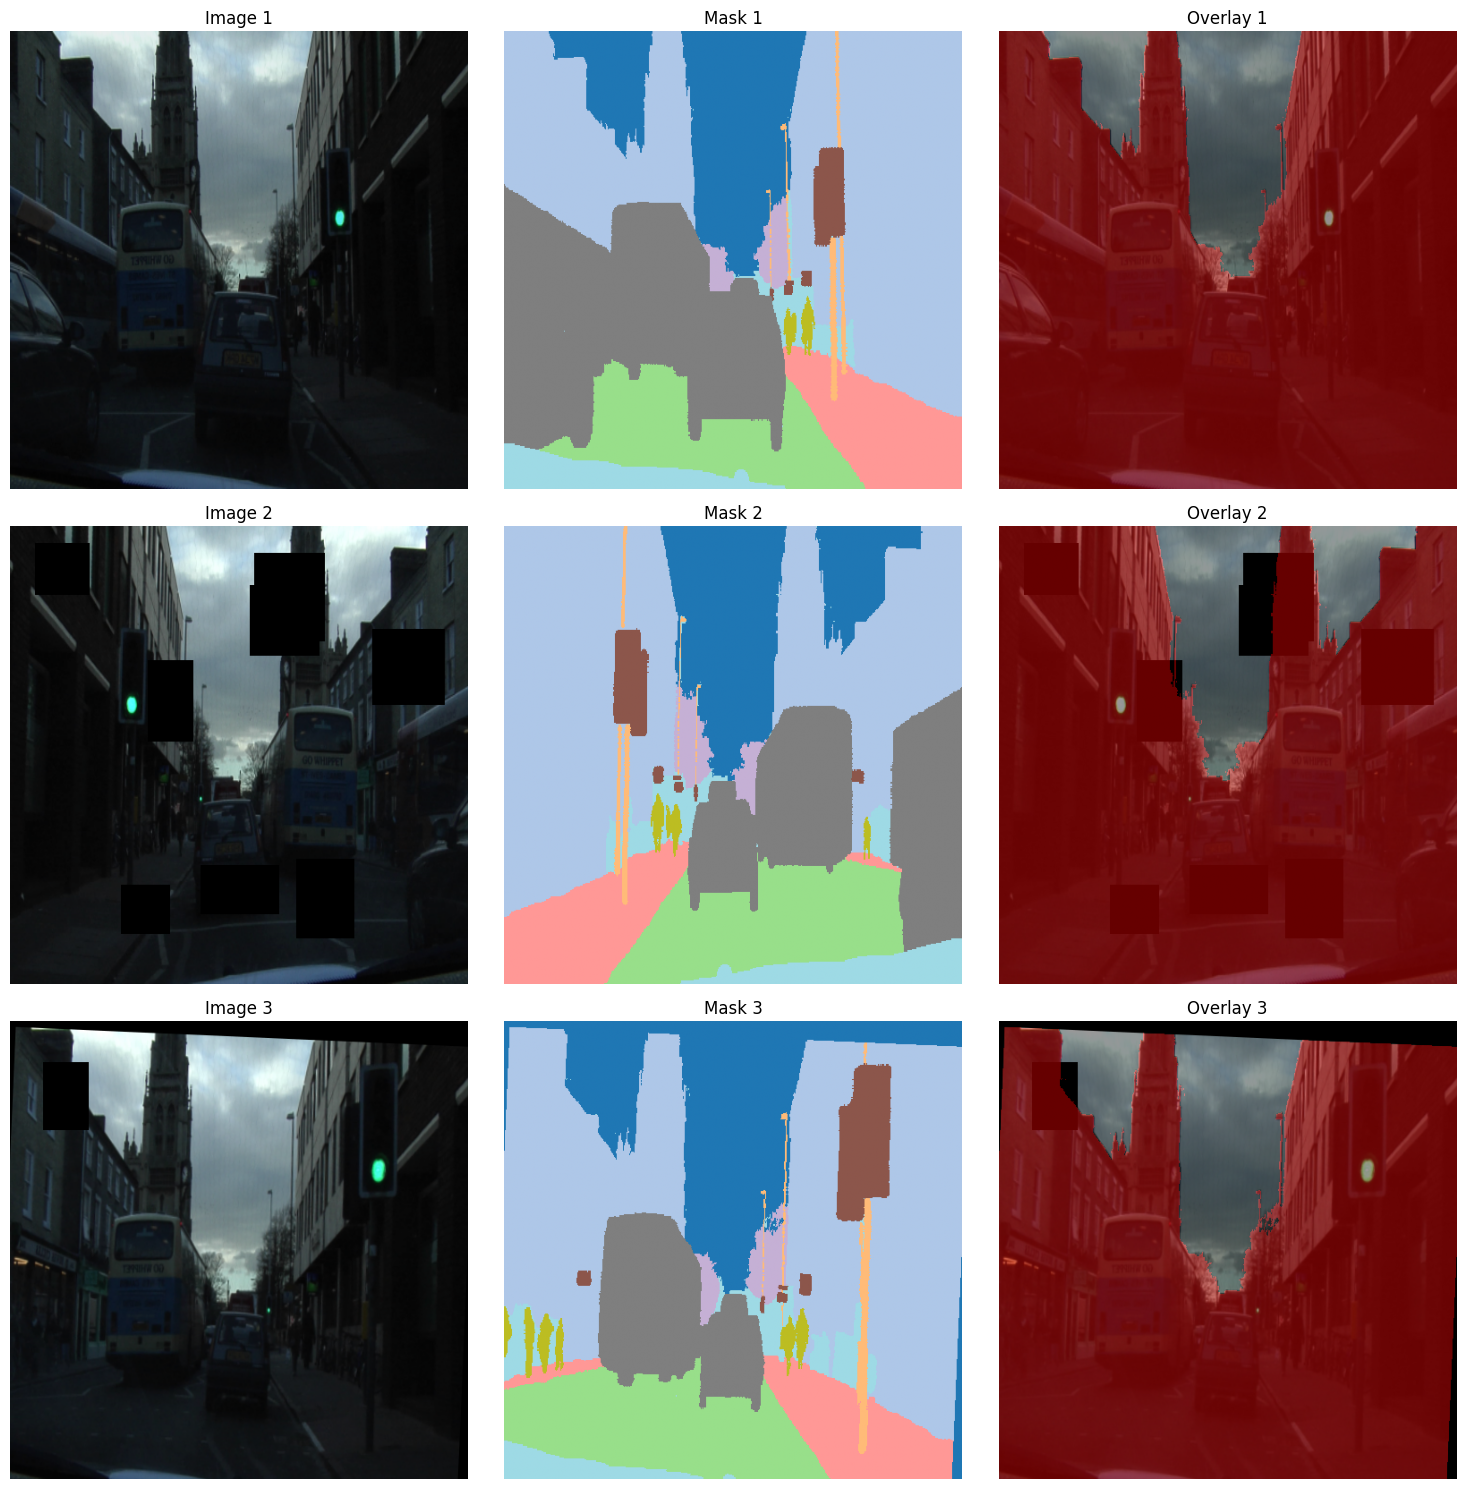

Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([512, 512])
Mask unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 11])


In [10]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    image, mask = train_dataset[i]

    img_np = image.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_np * std + mean
    img_np = np.clip(img_np, 0, 1)

    mask_np = mask.numpy()

    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f'Image {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask_np, cmap='tab20', vmin=0, vmax=11)
    axes[i, 1].set_title(f'Mask {i+1}')
    axes[i, 1].axis('off')

    overlay = img_np.copy()
    mask_colored = np.zeros_like(img_np)
    mask_colored[mask_np > 0] = [1, 0, 0]
    overlay = overlay * 0.6 + mask_colored * 0.4

    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title(f'Overlay {i+1}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Mask unique values: {torch.unique(mask)}")


## Инициализация модели

Создаём модель UNet и Lightning модуль для обучения.


In [11]:
unet_module = UNetModule(
    model=model,
    learning_rate=3e-4
)

sample_input = torch.randn(1, 3, 256, 256)
with torch.no_grad():
    sample_output = unet_module(sample_input)

print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")
print(f"Model parameters: {sum(p.numel() for p in unet_module.parameters()):,}")


Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 12, 256, 256])
Model parameters: 32,522,700


## Обучение модели

Настраиваем callbacks и запускаем обучение с использованием PyTorch Lightning.


In [12]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_iou',
    mode='max',
    save_top_k=1,
    filename='unet-{epoch:02d}-{val_iou:.4f}',
    save_last=True
)

early_stop_callback = EarlyStopping(
    monitor='val_iou',
    mode='max',
    patience=10,
    verbose=True
)

logger = TensorBoardLogger('lightning_logs', name='unet_segmentation')

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=logger,
    log_every_n_steps=10,
    val_check_interval=0.5
)

trainer.fit(unet_module, train_loader, val_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ Unet │ 32.5 M │ train │     0 │
└───┴───────┴──────┴────────┴───────┴───────┘

Trainable params: 32.5 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 32.5 M                                                                                               
Total estimated model params size (MB): 130                                                                        
Modules in train mode: 223                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou improved. New best score: 0.207
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou improved by 0.079 >= min_delta = 0.0. New best score: 0.286
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.288
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou improved by 0.032 >= min_delta = 0.0. New best score: 0.320
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou improved by 0.055 >= min_delta = 0.0. New best score: 0.375
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.378
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou improved by 0.014 >= min_delta = 0.0. New best score: 0.391
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.395
INFO:pytorch_lightning.callbacks.early_stopp

## Оценка на тестовом датасете

Оцениваем качество модели на тестовом датасете.


In [13]:
best_model_path = checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")


Best model path: lightning_logs/unet_segmentation/version_0/checkpoints/unet-epoch=43-val_iou=0.6472.ckpt


## Визуализация результатов

Визуализируем предсказания модели на нескольких примерах из валидационного датасета.


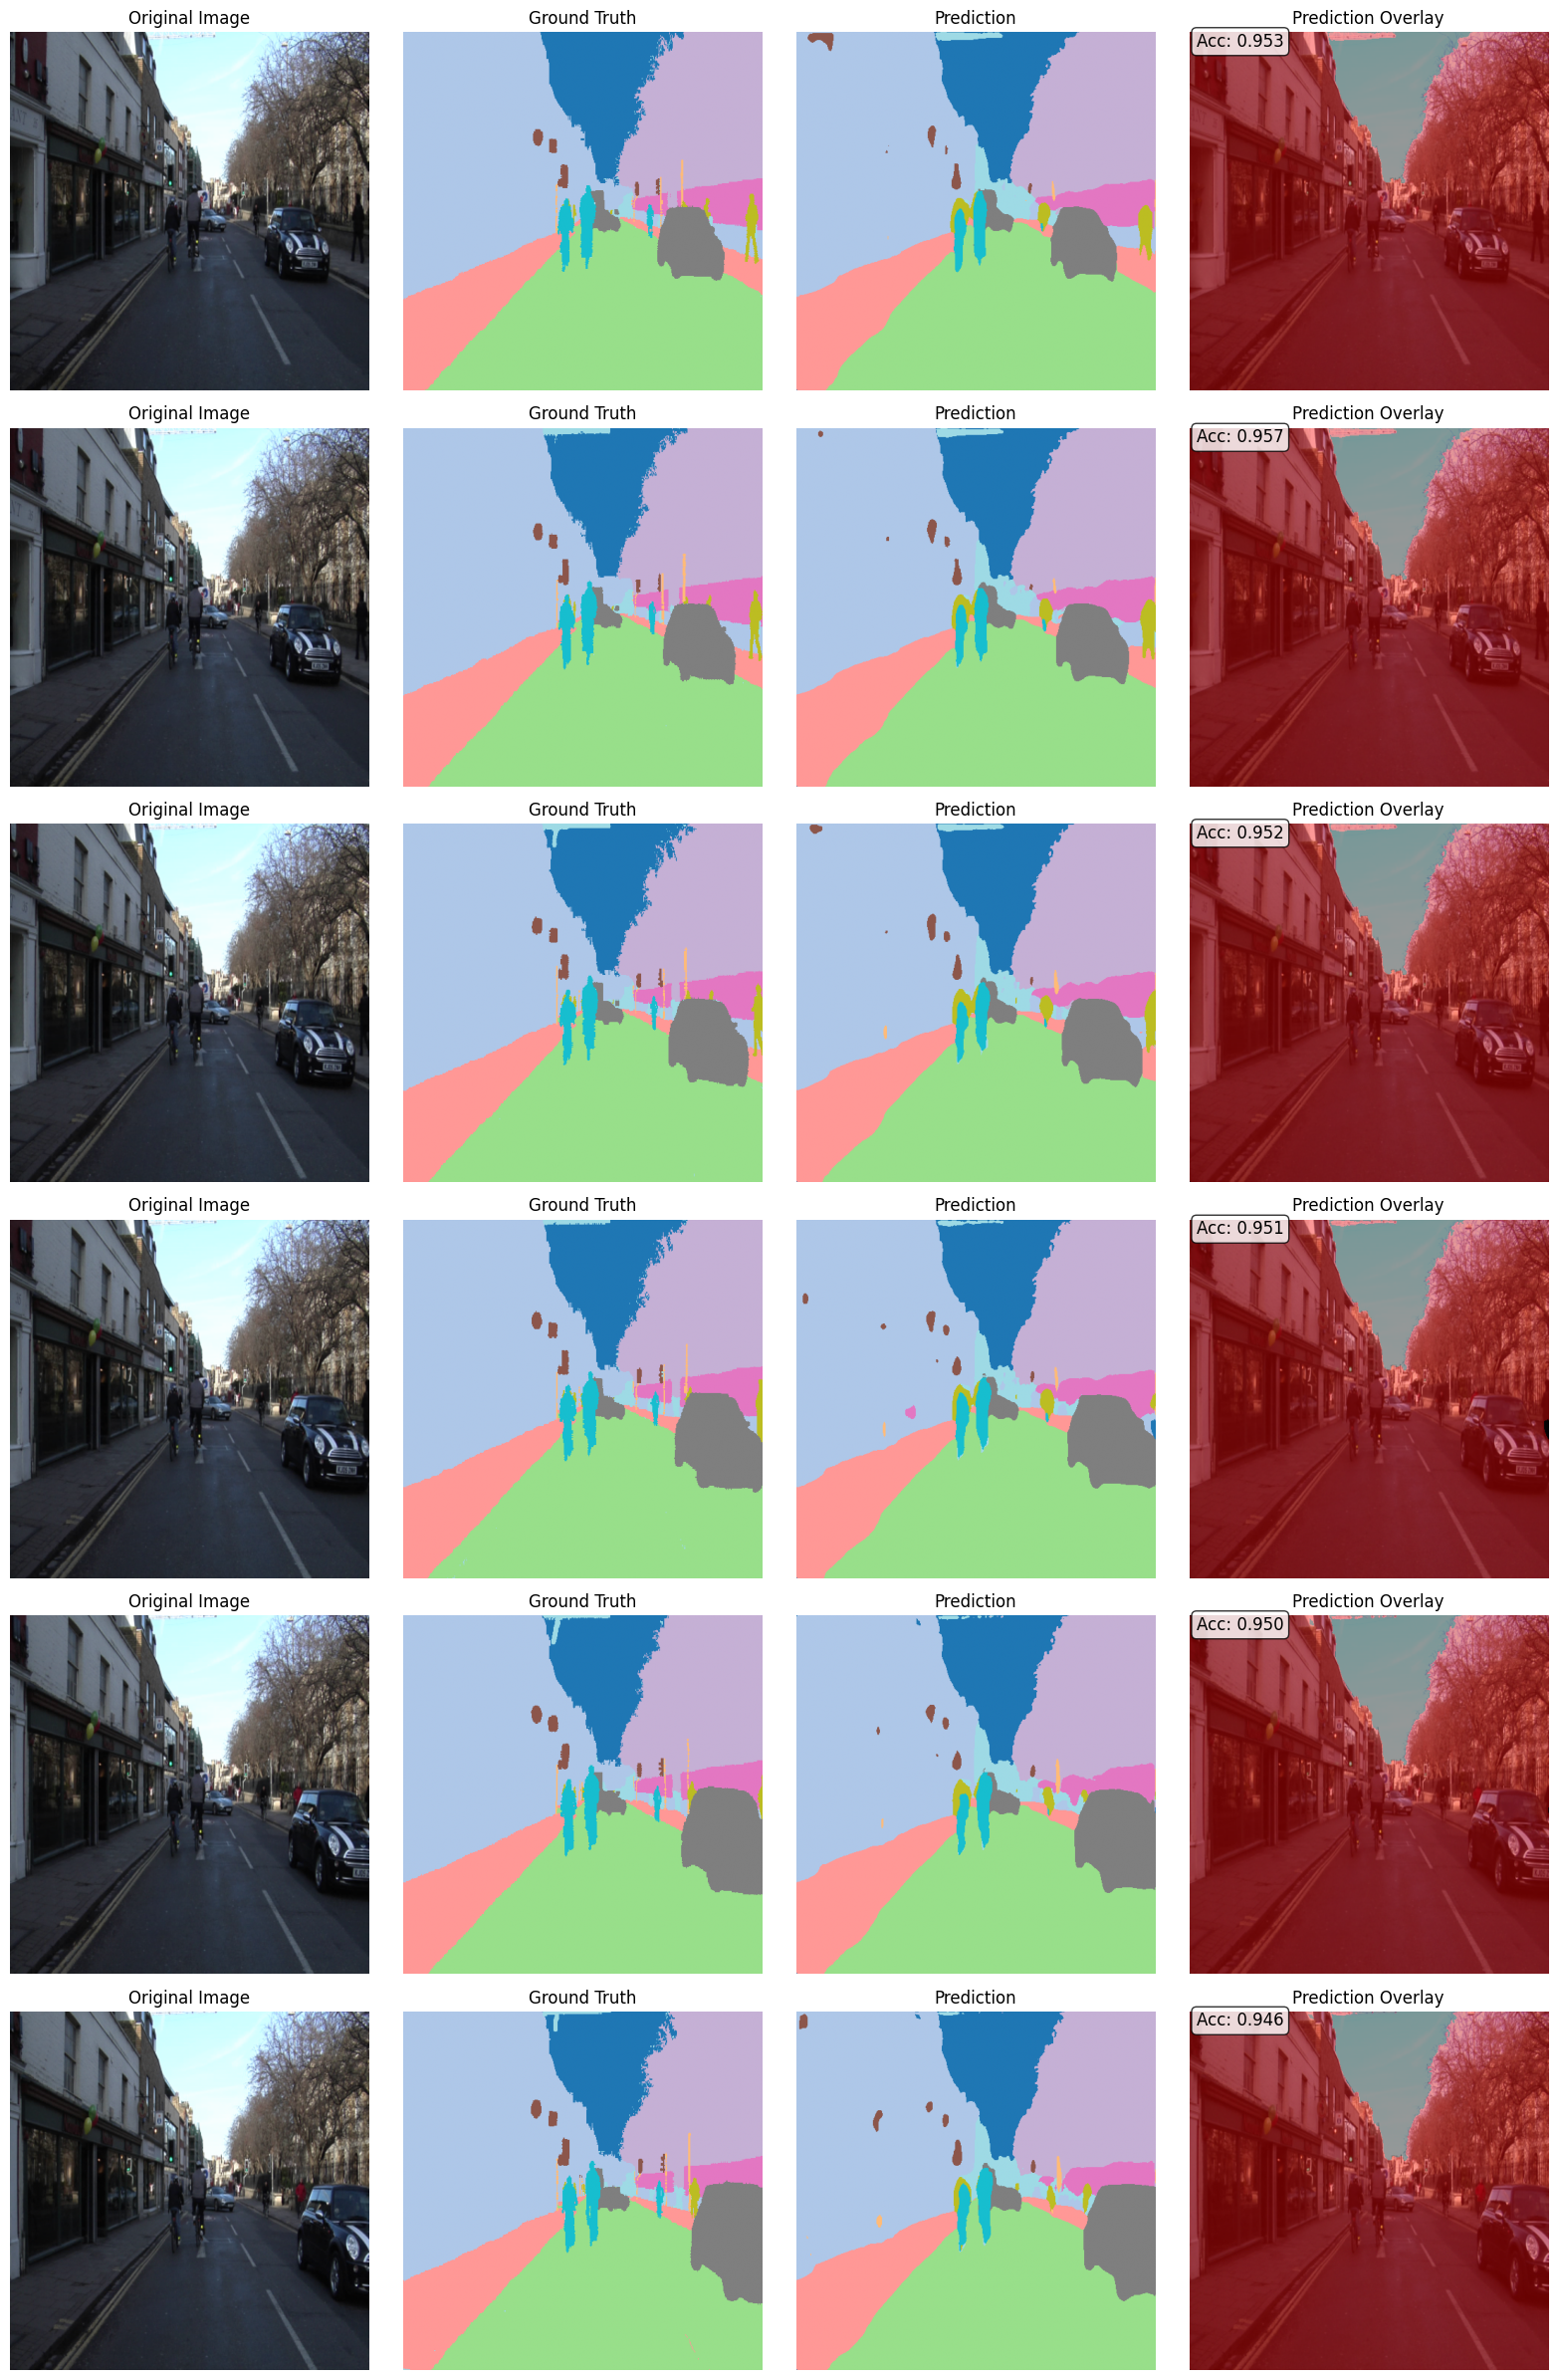

In [14]:
unet_module.eval()
device = next(unet_module.parameters()).device

num_samples = 6
fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

with torch.no_grad():
    for idx in range(num_samples):
        image, mask = val_dataset[idx]
        image_batch = image.unsqueeze(0).to(device)

        logits = unet_module(image_batch)
        pred = torch.argmax(logits, dim=1).cpu().squeeze()

        img_np = image.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = img_np * std + mean
        img_np = np.clip(img_np, 0, 1)

        mask_np = mask.numpy()
        pred_np = pred.numpy()

        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title('Original Image')
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(mask_np, cmap='tab20', vmin=0, vmax=11)
        axes[idx, 1].set_title('Ground Truth')
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(pred_np, cmap='tab20', vmin=0, vmax=11)
        axes[idx, 2].set_title('Prediction')
        axes[idx, 2].axis('off')

        overlay = img_np.copy()
        pred_colored = np.zeros_like(img_np)
        pred_colored[pred_np > 0] = [1, 0, 0]
        overlay = overlay * 0.6 + pred_colored * 0.4

        axes[idx, 3].imshow(overlay)
        axes[idx, 3].set_title('Prediction Overlay')
        axes[idx, 3].axis('off')

        correct = (pred_np == mask_np).sum()
        total = mask_np.size
        pixel_acc = correct / total
        axes[idx, 3].text(10, 20, f'Acc: {pixel_acc:.3f}',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                          fontsize=12, color='black')

plt.tight_layout()
plt.show()


## Метрики на валидационном датасете

Вычисляем детальные метрики на валидационном датасете.


In [15]:
device = 'cpu'

def compute_metrics(preds, targets, n_classes=12):
    ious = []
    for cls in range(n_classes):
        pred_cls = (preds == cls)
        target_cls = (targets == cls)
        intersection = (pred_cls & target_cls).float().sum((1, 2))
        union = (pred_cls | target_cls).float().sum((1, 2))
        iou = (intersection + 1e-6) / (union + 1e-6)
        ious.append(iou.mean().item())

    mean_iou = np.mean(ious)

    correct = (preds == targets).float().sum((1, 2))
    total = targets.numel() // targets.shape[0]
    pixel_acc = correct.sum().item() / (targets.shape[0] * total)

    return {
        'mean_iou': mean_iou,
        'iou_per_class': ious,
        'pixel_acc': pixel_acc
    }

unet_module.eval()
all_preds = []
all_targets = []

val_loader_eval = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

with torch.no_grad():
    for images, masks in tqdm(val_loader_eval, desc="Evaluating"):
        images = images.to(device)
        logits = unet_module(images)
        preds = torch.argmax(logits, dim=1).cpu()

        all_preds.append(preds)
        all_targets.append(masks)

all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

metrics = compute_metrics(all_preds, all_targets, n_classes=12)

camvid_classes = ['Sky', 'Building', 'Column-Pole', 'Road', 'Sidewalk', 'Tree', 'Sign-Symbol', 'Fence', 'Car', 'Pedestrian', 'Bicyclist', 'Void']

print("="*60)
print("Validation Metrics:")
print("="*60)
print(f"Mean IoU: {metrics['mean_iou']:.4f}")
print(f"Pixel Accuracy: {metrics['pixel_acc']:.4f}")
print("\nIoU per class:")
for cls_name, iou in zip(camvid_classes, metrics['iou_per_class']):
    print(f"  {cls_name}: {iou:.4f}")
print("="*60)


Evaluating: 100%|██████████| 13/13 [02:47<00:00, 12.92s/it]


Validation Metrics:
Mean IoU: 0.6425
Pixel Accuracy: 0.9246

IoU per class:
  Sky: 0.9409
  Building: 0.8523
  Column-Pole: 0.0852
  Road: 0.9693
  Sidewalk: 0.8708
  Tree: 0.9017
  Sign-Symbol: 0.5042
  Fence: 0.6303
  Car: 0.6958
  Pedestrian: 0.3334
  Bicyclist: 0.6598
  Void: 0.2666


С resnet50, дропаутом, оптимизатором adamw, размером картинки 512x512, elastictransform и focal_loss смог получить 0.666 (потом к сожалению потерял этот вариант и вернул только 0.6425)